In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import os
import seaborn as sns
import random 
import dask
import babet as bb
from moarpalettes import get_palette
from cartopy import crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as patches
from cmcrameri import cm
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import FuncFormatter, ScalarFormatter
from moarpalettes import get_palette

sns.set_theme(style="white")
sns.set_style("white")

random.seed(10)
# inidates = ['2023-10-11', '2023-10-15', '2023-10-17']
inidates = ['2023-10-15', '2023-10-17']
experiments = ['pi', 'curr', 'incr']

dask.config.set(**{'array.slicing.split_large_chunks': True})

In [2]:
color_palette = get_palette.Petroff6().to_sn_palette()
color_palette

[(0.3411764705882353, 0.5647058823529412, 0.9882352941176471),
 (0.9725490196078431, 0.611764705882353, 0.12549019607843137),
 (0.8941176470588236, 0.1450980392156863, 0.21176470588235294),
 (0.5882352941176471, 0.2901960784313726, 0.5450980392156862),
 (0.611764705882353, 0.611764705882353, 0.6313725490196078),
 (0.47843137254901963, 0.12941176470588237, 0.8666666666666667)]

In [3]:
# Plot settings
uk = [-10.5, 9.5, 45.5, 61.3] # longitude min, longitude max, latitude min, latitude max
northsea = [-17, 20, 40, 70]

# Load data

In [4]:
micas_sfc = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/access-micas/micas_clean.nc')

In [5]:
# FBA ACCESS

# check if file exists
if not os.path.exists('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/access-micas/micas_clean_dynamics.nc'):
    # precip
    tmp1 = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/access-micas/micas_hus_highGHG.nc').expand_dims(climate=["future1"])
    tmp2 =xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/access-micas/micas_hus_lowGHG.nc').expand_dims(climate=["1870"])
    tmp3 = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/access-micas/micas_hus_ctrl.nc').expand_dims(climate=["present"])
    ds = xr.concat([tmp1, tmp2, tmp3], dim="climate").rename_dims({"z1_p_level": "level"}).rename_vars({"hus": "q", 'z1_p_level': 'level'})

    # vertical velocity
    tmp1 = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/access-micas/micas_wa_highGHG.nc').expand_dims(climate=["future1"]).rename_dims({"z1_p_level": "level"}).rename_vars({"wa": "w", 'z1_p_level': 'level'})
    tmp2 = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/access-micas/micas_wa_lowGHG.nc').expand_dims(climate=["1870"]).rename_dims({"z1_p_level": "level"}).rename_vars({"wa": "w", 'z1_p_level': 'level'})
    tmp3 = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/access-micas/micas_wa_ctrl.nc').expand_dims(climate=["present"]).rename_dims({"z1_p_level": "level"}).rename_vars({"wa": "w", 'z1_p_level': 'level'})
    # ds = xr.merge([ds, xr.concat([tmp1, tmp2, tmp3], dim="climate")], compat="override")
    micas_pl = xr.merge([ds, xr.concat([tmp1, tmp2, tmp3], dim="climate")], compat="override")

    # mean sea level pressure
    # tmp1 = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/access-micas/micas_psl_highGHG.nc').expand_dims(climate=["future1"])
    # tmp2 = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/access-micas/micas_psl_lowGHG.nc').expand_dims(climate=["1870"])
    # tmp3 = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/access-micas/micas_psl_ctrl.nc').expand_dims(climate=["present"])
    # micas_pl = xr.merge([ds, xr.concat([tmp1, tmp2, tmp3], dim="climate").rename({'psl': 'msl'})], compat="override")

    # Save to netcdf
    micas_pl.to_netcdf('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/access-micas/micas_clean_dynamics.nc')
else:
    print("importing from existing file")
    micas_pl = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/access-micas/micas_clean_dynamics.nc')

importing from existing file


In [6]:
def calculate_tcwv(ds, q_var='q', g=9.81):
    """
    Calculate Total Column Water Vapor (TCWV) from specific humidity on pressure levels.
    
    Parameters:
    ds : xarray.Dataset
        Dataset containing specific humidity and pressure levels.
    q_var : str, optional
        Name of the specific humidity variable in the dataset. Default is 'q'.
    g : float, optional
        Acceleration due to gravity (m/s^2). Default is 9.81.
    
    Returns:
    xarray.DataArray
        Total Column Water Vapor (kg/m^2)
    """
    q = ds[q_var]  # Specific humidity (kg/kg)
    
    dp = ds.level.diff('level').rename('dp')*100

    # Align ΔP with the original dataset (it will be one less in size)
    dp = dp.assign_coords(p=ds['level'].isel(level=slice(1, None)))

    # # Integrate using the trapezoidal rule
    tcwv = (q.isel(level=slice(1, None)) * dp / g).sum(dim='level')
        
    return tcwv

def calc_average_w(ds, lower=850, upper=250, level_name='level'):

    # Rename dimension level if necessary
    if not level_name == 'level':
        ds = ds.rename({level_name: 'level'})

    ds = ds.sel(level=slice(upper, lower))
    
    # Compute the pressure thickness (ΔP) between levels
    # The last dimension should be the pressure dimension
    delta_p = ds.level.diff('level').rename('delta_p')

    # Align ΔP with the original dataset (it will be one less in size)
    delta_p = delta_p.assign_coords(p=ds['level'].isel(level=slice(1, None)))

    # Compute the mass-weighted vertical velocity
    weighted_w = ds['w'].isel(level=slice(1, None)) * delta_p

    # Compute the mass-weighted average
    mass_weighted_average = (weighted_w.sum(dim='level') / delta_p.sum(dim='level')).rename('mass_weighted_w')

    # Add the result to your dataset
    # ds['mass_weighted_w'] = mass_weighted_average
    
    return mass_weighted_average

# TCW and vertically averaged w

In [7]:
micas_pl['tcwv'] = calculate_tcwv(micas_pl, q_var='q')
micas_pl['tcwv'].attrs['units'] = 'kg/m^2'
micas_pl['tcwv'].attrs['long_name'] = 'Total Column Water Vapor'

In [8]:
micas_pl

<xarray.Dataset>
Dimensions:  (level: 10, climate: 3, member: 33, time: 6, lat: 37, lon: 26)
Coordinates:
  * level    (level) float32 200.0 250.0 300.0 400.0 ... 700.0 850.0 925.0 1e+03
  * climate  (climate) object 'future1' '1870' 'present'
  * lat      (lat) float32 45.0 45.56 46.11 46.67 ... 63.33 63.89 64.44 65.0
  * time     (time) datetime64[ns] 2023-10-18 2023-10-19 ... 2023-10-23
  * lon      (lon) float32 -10.83 -10.0 -9.167 -8.333 ... 7.5 8.333 9.167 10.0
Dimensions without coordinates: member
Data variables:
    q        (climate, member, time, level, lat, lon) float32 ...
    w        (climate, member, time, level, lat, lon) float32 ...
    tcwv     (climate, member, time, lat, lon) float32 39.14 41.74 ... 7.372
Attributes: (12/25)
    model_id:                ACCESS-S2
    distribution_statement:  The data are subject to the distribution terms o...
    creator_name:            Bureau of Meteorology
    copyright:               (C) Copyright Commonwealth of Australia (2017), ...
    acknowledgement:         Australian Bureau of Meteorology, Commonwealth o...
    title:                   ACCESS-S2
    ...                      ...
    input_file_format:       UM ancillary
    input_uri:               file:///home/548/lz3062/cylc-run/babet_20231017_...
    input_word_length:       8
    input_byte_ordering:     big_endian
    history:                 Fri Jul 26 03:11:21 2024: ncks -O -v hus pd20231...
    NCO:                     netCDF Operators version 4.9.2 (Homepage = http:...

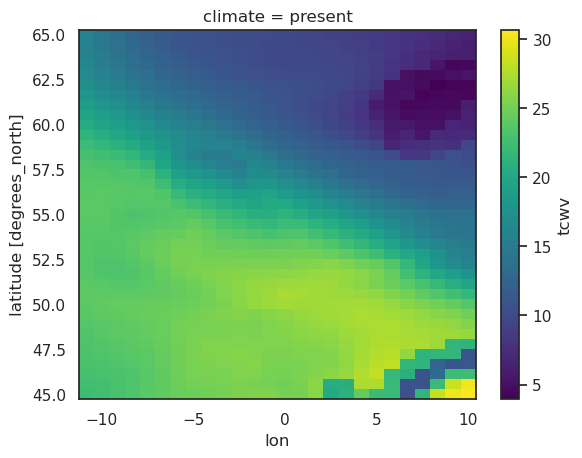

In [9]:
micas_pl.tcwv.sel(time=slice('2023-10-19 00', '2023-10-22 00')).mean(dim=['time', 'member']).sel(climate='present').plot()

In [10]:
micas_pl['av_w'] = calc_average_w(micas_pl, lower=850, upper=250, level_name='level')
micas_pl['av_w'].attrs['units'] = 'm/s'
micas_pl['av_w'].attrs['long_name'] = 'Mass weighted vertical velocity'
micas_pl['av_w'].attrs['description'] = 'Mass weighted vertical velocity between 850 and 250 hPa'

In [11]:
micas_tempmean = micas_pl.sel(time=slice('2023-10-19 00', '2023-10-22 00')).mean(dim='time').compute()
micas_sfc['msl'] = micas_sfc['msl']/100 
micas_tempmean_sfc = micas_sfc.sel(time=slice('2023-10-19 00', '2023-10-22 00')).mean(dim='time').compute()

# Plot

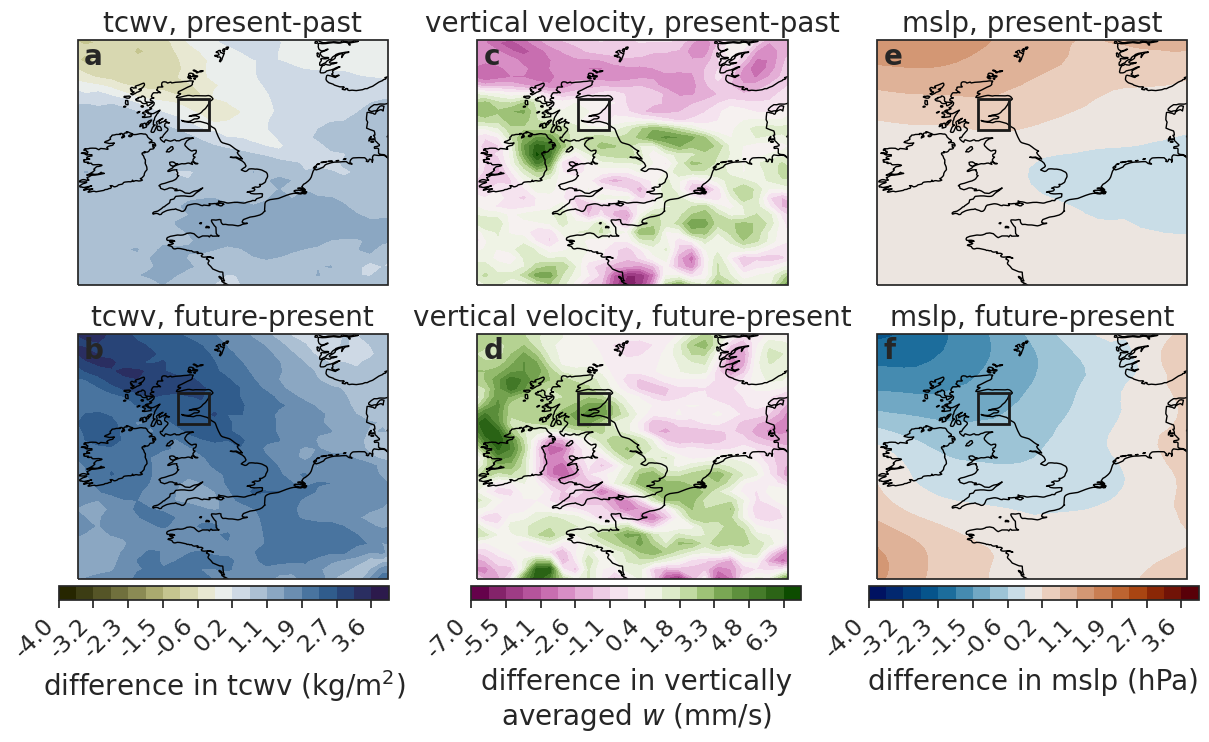

In [13]:
# Create figure
fs = 20
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(15, 7), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot saturation specific humidity
vmax = 4
plot1 = (micas_tempmean.sel(climate='present')-micas_tempmean.sel(climate='1870')).tcwv.mean('member').plot.contourf(
    cmap=cm.broc_r,vmin=-1*vmax, vmax=vmax,
    levels=20, ax=axes[0, 0], add_colorbar=False  # Disable individual colorbars
)
plot2 = (micas_tempmean.sel(climate='future1')-micas_tempmean.sel(climate='present')).tcwv.mean('member').plot.contourf(
    cmap=cm.broc_r, vmin=-1*vmax, vmax=vmax,
    levels=20, ax=axes[1, 0], add_colorbar=False  # Disable individual colorbars
)

# Plot vertical velocity
vmax = 7
plot3 = ((micas_tempmean.sel(climate='present')-micas_tempmean.sel(climate='1870')).av_w.mean('member')*1000).plot.contourf(
    cmap=cm.bam, vmin=-1*vmax, vmax=vmax,
    levels=20, ax=axes[0,1], add_colorbar=False  # Disable individual colorbars
)
plot4 = ((micas_tempmean.sel(climate='future1')-micas_tempmean.sel(climate='present')).av_w.mean('member')*1000).plot.contourf(
    cmap=cm.bam, vmin=-1*vmax, vmax=vmax,
    levels=20, ax=axes[1,1], add_colorbar=False  # Disable individual colorbars
)

# Plot mean sea level pressure
vmax = 4
plot5 = (micas_tempmean_sfc.sel(climate='present')-micas_tempmean_sfc.sel(climate='1870')).msl.mean('member').plot.contourf(
    cmap=cm.vik, vmin=-1*vmax, vmax=vmax,
    levels=20, ax=axes[0,2], add_colorbar=False  # Disable individual colorbars
)
plot6= (micas_tempmean_sfc.sel(climate='future1')-micas_tempmean_sfc.sel(climate='present')).msl.mean('member').plot.contourf(
    cmap=cm.vik, vmin=-1*vmax, vmax=vmax,
    levels=20, ax=axes[1,2], add_colorbar=False  # Disable individual colorbars
)

# Add horizontal colorbars
cbar_ax1 = fig.add_axes([0.12, 0.08, 0.22, 0.02])  # Bottom of first column
cbar1 = fig.colorbar(plot1, cax=cbar_ax1, orientation="horizontal", label="difference in tcwv (kg/m$^2$)")
cbar1.set_label("difference in tcwv (kg/m$^2$)", fontsize=fs)
cbar1.ax.xaxis.set_label_position('bottom')
cbar1.formatter = FormatStrFormatter("%.1f")  # Restrict to 2 decimal places
cbar1.ax.tick_params(labelsize=fs-3)
cbar1.update_ticks()

cbar_ax2 = fig.add_axes([0.395, 0.08, 0.22, 0.02])  # Bottom of second column
cbar2 = fig.colorbar(plot3, cax=cbar_ax2, orientation="horizontal", label="difference in vertically averaged $w$ (mm/s)")
cbar2.set_label("difference in vertically\naveraged $w$ (mm/s)", fontsize=fs)
cbar2.ax.xaxis.set_label_position('bottom')
cbar2.formatter = FormatStrFormatter("%.1f")  # Restrict to 2 decimal places
cbar2.ax.tick_params(labelsize=fs-3)
cbar2.update_ticks()

cbar_ax3 = fig.add_axes([0.66, 0.08, 0.22, 0.02])  # Bottom of third column
cbar3 = fig.colorbar(plot5, cax=cbar_ax3, orientation="horizontal", label="difference in mslp (hPa)")
cbar3.set_label("difference in mslp (hPa)", fontsize=fs)
cbar3.ax.tick_params(labelsize=fs-3)
cbar3.ax.xaxis.set_label_position('bottom')
cbar3.formatter = FormatStrFormatter("%.1f")  # Restrict to 2 decimal places
cbar3.update_ticks()

for cbar in [cbar1, cbar2, cbar3]:  
    for label in cbar.ax.get_xticklabels():  # For horizontal colorbars  
        label.set_rotation(45)  
        label.set_ha('right')  # Align labels to the right for better readability


# Add figure labels
axes[0, 0].text(0.02, 0.9, "a", transform=axes[0, 0].transAxes, fontsize=fs, fontweight="bold")
axes[1, 0].text(0.02, 0.9, "b", transform=axes[1, 0].transAxes, fontsize=fs, fontweight="bold")
axes[0, 1].text(0.02, 0.9, "c", transform=axes[0, 1].transAxes, fontsize=fs, fontweight="bold")
axes[1, 1].text(0.02, 0.9, "d", transform=axes[1, 1].transAxes, fontsize=fs, fontweight="bold")
axes[0, 2].text(0.02, 0.9, "e", transform=axes[0, 2].transAxes, fontsize=fs, fontweight="bold")
axes[1, 2].text(0.02, 0.9, "f", transform=axes[1, 2].transAxes, fontsize=fs, fontweight="bold")

# Apply Cartopy settings to both axes
titles = [f"tcwv, present-past", f"vertical velocity, present-past", f"mslp, present-past",
         f"tcwv, future-present", f"vertical velocity, future-present",  f"mslp, future-present"]
for ax, title in zip(axes.flatten(), titles):
    ax.set_extent(uk, crs=ccrs.PlateCarree())  # Set map extent
    ax.add_feature(cfeature.LAND, edgecolor='black', linewidth=0.8)  # Add land borders
    ax.add_feature(cfeature.OCEAN, facecolor='white')  # Mask ocean
    ax.coastlines()  # Add coastlines
    ax.set_title(title, fontsize=fs)  # Set

    rectangle = patches.Rectangle((-4, 55.5), 2, 2, linewidth=2, 
                                edgecolor='k', 
                                facecolor='none',
                                transform=ccrs.PlateCarree())
    ax.add_patch(rectangle)
    rectangle.set_zorder(17)
plt.subplots_adjust(right=0.88)

# save plot
plt.savefig('../notebooks/figures/C01_MICAS_dynamics.png', dpi=600, bbox_inches='tight')
plt.savefig('../notebooks/figures/C01_MICAS_dynamics.pdf')